<a href="https://colab.research.google.com/github/jayantapy/Hate-Speech-Detection/blob/main/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
df.shape

(31962, 3)

HATE TWEETS

In [6]:
hate_tweets = df[df.label == 1]
hate_tweets.head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


**NORMAL TWEETS**

In [7]:
normal_tweets = df[df.label == 0]
normal_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


(-0.5, 399.5, 199.5, -0.5)

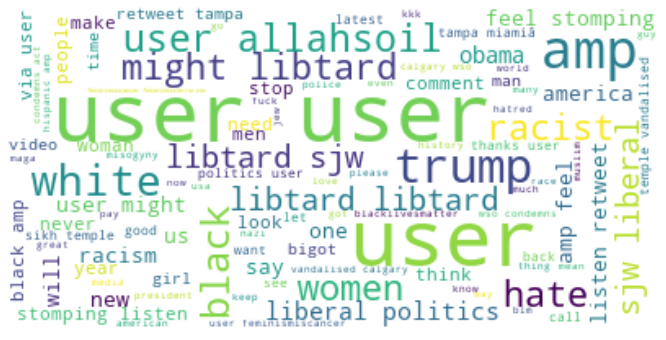

In [8]:
# Displaying hate words clouds
from os import path
from PIL import Image
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
text = " ".join(tweets for tweets in hate_tweets.tweet)
wordcloud = WordCloud(max_font_size = 50,max_words = 100,background_color = 'white').generate(text)
plt.figure(figsize=(20,6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")

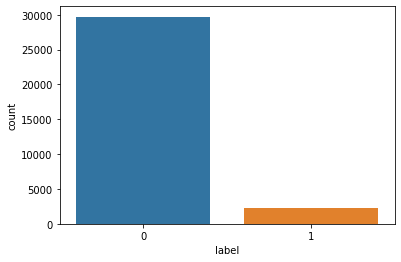

In [9]:
sns.countplot(x = 'label',data = df)

**Showing the percentage of hate tweets and normal tweets**

In [10]:
df_stats = df[['label','tweet']].groupby('label').count().reset_index()
df_stats.columns = ['label','count']
df_stats['percentage'] = (df_stats['count']/df_stats['count'].sum()) * 100
df_stats

,label,count,percentage
0,0,29720,92.98542
1,1,2242,7.01458


Data Preprocessing

In [11]:
import re
def preprocess(tweet):
  return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [12]:
df['processed_tweets'] = df['tweet'].apply(preprocess)
df.head()

,id,label,tweet,processed_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


**As the dataset is higly imbalanced, we have to balance it using oversampling.**

In [13]:
normal_count = df[df['label'] == 0]['processed_tweets'].count()
hate_count_df = df[df['label'] == 1]
normal_count_df = df[df['label'] == 0]
df_hate_count_oversampled = hate_count_df.sample(normal_count, replace=True)
df_oversampled = pd.concat([normal_count_df, df_hate_count_oversampled], axis=0)

In [14]:
print("Random Over Sampling: ")
print(df_oversampled['label'].value_counts())

Random Over Sampling: 
1    29720
0    29720
Name: label, dtype: int64


Splitting data into training and test sets

In [15]:
X = df_oversampled['processed_tweets']
y = df_oversampled['label']

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer

BUILDING A PIPELINE MODEL TO TEST ALL CLASSIFICATION ALGORITHMS

In [17]:
def classify(model,X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

  #Model training
  pipeline_model = Pipeline([('vect',CountVectorizer()),
                             ('tfidf',TfidfTransformer()),
                             ('clf',model)])
  pipeline_model.fit(X_train,y_train)

  pred = pipeline_model.predict(X_test)
  print(classification_report(y_test,pred))
  print('\n')
  print('The accuracy of model is ',accuracy_score(y_test,pred))

LOGISTIC REGRESSION

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
classify(model,X,y)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7430
           1       0.95      0.99      0.97      7430

    accuracy                           0.97     14860
   macro avg       0.97      0.97      0.97     14860
weighted avg       0.97      0.97      0.97     14860



The accuracy of model is  0.9685733512786002


SUPPORT VECTOR CLASSIFIER(SVC)

In [20]:
from sklearn import svm
model = svm.LinearSVC()
classify(model,X,y)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7430
           1       0.97      1.00      0.98      7430

    accuracy                           0.98     14860
   macro avg       0.98      0.98      0.98     14860
weighted avg       0.98      0.98      0.98     14860



The accuracy of model is  0.9839838492597578


**RANDOM FOREST CLASSIFIER**

In [21]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
classify(model,X,y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7430
           1       1.00      1.00      1.00      7430

    accuracy                           1.00     14860
   macro avg       1.00      1.00      1.00     14860
weighted avg       1.00      1.00      1.00     14860



The accuracy of model is  0.9977119784656797


MULTINOMIAL NAIVE BAYES

In [22]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
classify(model,X,y)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7430
           1       0.92      0.99      0.95      7430

    accuracy                           0.95     14860
   macro avg       0.95      0.95      0.95     14860
weighted avg       0.95      0.95      0.95     14860



The accuracy of model is  0.95


So, from all the above algorithms, Random Forest gave the highest accuracy with 99.7% accuracy.